In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from data.mix_gaussian import MixedGaussian
import mine

In [17]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

In [18]:
d = 2  # d is the dimension of X and Y. The dimension of joint mix-gaussian distribution is 2*d

rho = 0.9
sample_size = 400

X = np.zeros((sample_size, d))
Y = np.zeros((sample_size, d))

mg = MixedGaussian(sample_size=sample_size, rho1=rho, rho2=-rho)

hx, hy, hxy, mi = mg.ground_truth

"""
Splitting the 2-d Mix-Gaussian data into 2 components, and assign them to X and Y respectively. 
Generate 2-d Mix-Gaussian data from the same distribution and repeat this step for d times. 
(X,Y) is a mixed gaussian distribution; but X and Y are not.
"""
for i in range(d):
    data = mg.data
    X[:, i] = data[:, 0]
    Y[:, i] = data[:, 1]

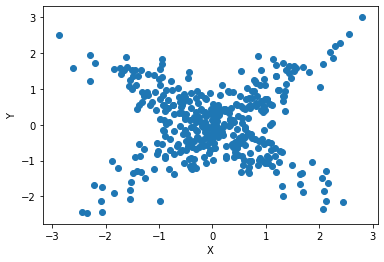

In [19]:
plt.figure()
plt.scatter(X[:, 0], Y[:, 0])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [20]:
import scipy.stats as st
pdf = st.multivariate_normal(
                mean=np.zeros(d),
                cov=np.identity(d))
density_x = pdf.pdf(X)   # p(x)
density_y = pdf.pdf(Y)   # p(y)
density_xy = density_x * density_y
# The cross entropy of the reference distribution, i.e. product of marginal distribution
H_crossentropy = -np.log(density_xy).mean()

In [21]:
# Ground truth of entropy of mixed gaussian distribution (X,Y)
# As the 2-d mix-gaussian data is generated independently, the entropy of (X, Y) is d times 
# the entropy of the 2-d mix-gaussian data.
h_xy = hxy * d

D:\ProgramFile\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


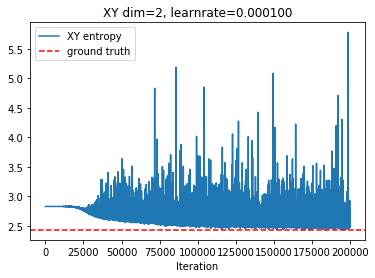

In [22]:
# -------------------------- Training ----------------------------- #
# Using Neural Network to estimate the entropy of the generated Gaussian distribution

batch_size = 100
lr = 1e-4
ma_rate = 0.1

NN = mine.MINE(torch.Tensor(X),torch.Tensor(Y),batch_size=batch_size,lr=lr,ma_rate=ma_rate)

num_iteration = 200000

entropy_XY = []
dXY_list = []


for i in range(num_iteration):
    NN.step()
    dXY = NN.forward()
    entropy_XY.append(H_crossentropy - dXY)
    dXY_list.append(dXY)


plt.figure()
plt.plot(entropy_XY, label='XY entropy')
plt.axhline(h_xy, label='ground truth', linestyle='--', color='red')
plt.xlabel('Iteration')
plt.title('XY dim=%d, learnrate=%f' % (2 * d, lr))
plt.legend()
plt.savefig("dim=%d learnrate=%f.png" % (2*d,lr))
plt.show()